# Info


DQN Implemented with Tensorflow tf-agent module.

Using same environment as in [tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial#hyperparameters): `CartPole-v0`.

Purpose is to see hwo easy it is to use the tf-agent library and how the results compare to other implementations.

# Imports

In [12]:
import numpy as np
import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
import matplotlib.pyplot as plt
from tf_agents.agents.dqn import dqn_agent
plt.style.use('ggplot')


tf.__version__

'2.2.0'

# Hyperparameters

In [2]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Environment

In [3]:
env_name = 'CartPole-v0'#'LunarLander-v2'#'CartPole-v0'

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agent

In [4]:
fc_layer_params = (256,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# Policies

In [5]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [6]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [7]:
def compute_avg_return(environment, policy, num_episodes=10):
    """Metrics and Evaluation
    """
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


def collect_step(environment, policy, buffer):
    """Data Collection
    """
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    """Data Collection
    """
    for _ in range(steps):
        collect_step(env, policy, buffer)

# Replay Buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_policy, replay_buffer, steps=100)

In [8]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

In [9]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

print(iterator)

# Training the agent

In [10]:
for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()

#     if step % log_interval == 0:
#         print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(train_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


step = 1000: Average Return = 32.900001525878906
step = 2000: Average Return = 34.29999923706055
step = 3000: Average Return = 43.79999923706055
step = 4000: Average Return = 84.0999984741211
step = 5000: Average Return = 177.10000610351562
step = 6000: Average Return = 185.39999389648438
step = 7000: Average Return = 197.3000030517578
step = 8000: Average Return = 153.1999969482422
step = 9000: Average Return = 193.8000030517578
step = 10000: Average Return = 190.8000030517578
step = 11000: Average Return = 168.8000030517578
step = 12000: Average Return = 193.8000030517578
step = 13000: Average Return = 176.6999969482422
step = 14000: Average Return = 197.5
step = 15000: Average Return = 194.8000030517578
step = 16000: Average Return = 196.39999389648438
step = 17000: Average Return = 194.89999389648438
step = 18000: Average Return = 197.6999969482422
step = 19000: Average Return = 200.0
step = 20000: Average Return = 200.0


# Plots

(2.390000200271606, 250.0)

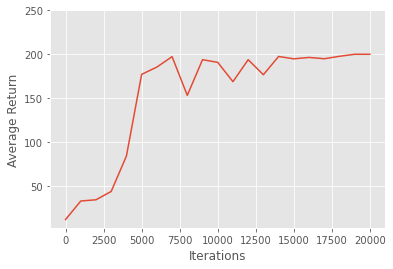

In [13]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)